**Assignment 1 Deep Learning COSC2779**

The goal of the assignment is to develop a deep convolutional neural network (CNN) architechture to predict the head pose of given image of a person.
The head pose is quantified by two values:

1.   Tilt : vertical angle of head.
2.   Pan : Horizontal angle of head.

we have a original data from head Pose Image Database published with N. Gourier,
D. Hall, J. L. Crowley, “Estimating Face Orientation from Robust Detection of Salient Facial Features”, Proceedings of ICPR International Workshop on Visual Observation of Deictic Gestures 2004.

The data set contains 2 main files 'train_data.csv' and 'test_data.csv' in which the image filenames are mentioned along with their person id and sequence id. All the images are present in 'modified_data.zip' folder.

The dataset contains two class lables namely tilt and pan. 
Tilt values varies in between +90 to -90 where negative values represent bottom and positive values represent top direction and this label have 9 different classes.

Pan values varies in between +90 to -90 and have 13 different classes. Here, negative values represent left direction while positive values represent right direction of a face.



# Mounting Drive and Loading required packages and libraries

In this section, before starting the experiement, we have to mount the google drive with our .ipynb file to read the data from the drive. 
We are also loading the required packages in this section so that we can use them in below coding cells.  
The next important step is to set up a tensorboard platform to check the performance realted matrices of the CNN model we are building for this experiment. 


In [38]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import keras.preprocessing.image as image 
import os

import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

# Setting up a basic plotter function to plot the performance graphs

the below code is to set up a plotter function which is used to plot graphs of the given model as per the provided performance metric. It will generate basic line graph for both training and validation data with solid and dotted line respectively.

In [40]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

# Reading data from the cloud splitting it into Training and Validation datasets.

Below code cell contains code to read the files 'train_data.csv' and 'test_data.csv' into google colab environment and splitting the train_data into training and validation datasets so that, we can perform the model training on the training data while try to generalize the performance of trained model on the validation data. 


In [41]:
# Reading the train and test data files from google cloud to colab environment.
DF = pd.read_csv("/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment1/Assign1/A1_data/train_data.csv")
DF_Test = pd.read_csv("/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment1/Assign1/A1_data/test_data.csv")

print(DF.shape)
print(DF.dtypes)
print(DF['tilt'].value_counts())
print(DF['pan'].value_counts())

(2325, 5)
filename     object
person_id     int64
series        int64
tilt          int64
pan           int64
dtype: object
 15    325
-15    325
 60    325
-60    325
 30    325
-30    325
 0     325
 90     25
-90     25
Name: tilt, dtype: int64
 0     225
 75    175
-75    175
 45    175
-45    175
 15    175
-15    175
 90    175
-90    175
 60    175
-60    175
 30    175
-30    175
Name: pan, dtype: int64


1. From the output of above cells, we can see that, the train_data.csv contains 
2325 image data and 5 feature columns namely, 'filename', 'person_id', 'series', 'tilt' and 'pan'.
2. We can see that, the data type of of our experiment labels 'tilt' and 'pan' are int64 which is numeric data. 
3. furthermore, we can see from above output that, the class label 'tilt' contain 9 unique values out of which +90 and -90 tilt values have minimum samples in the data. 
4. +90 and -90 represents highest and lowest vertical angles of head position.
5. As we can see the tilt and pan values varies in between fixed set of class values, we can use classification approch to predict the head position angles of unseen test data images.
6. We need to convert the class labels into str to make it as a classification problem.
7. For the classification purpose, we are encoding these class variable values as below to predict them for test data images.


---



In [42]:
DF['pan'] = DF['pan'].astype(str)
DF['tilt'] = DF['tilt'].astype(str)
DF['tilt'] = DF['tilt'].replace({"-90":"0" , "-60":"1", "-30":"2", "-15":"3", "0":"4", "15":"5", "30":"6", "60":"7", "90":"8"})
DF['pan'] = DF['pan'].replace({"-90":"0", "-75":"1", "-60":"2", "-45":"3", "-30":"4", "-15":"5", "0":"6", "15":"7", "30":"8", "45":"9", "60":"10", "75":"11", "90":"12"})

# We split the Training datatset into Training and Validation dataset by using 80:20 splitting (80% for Training and 20% for validation)
X_train,X_val = train_test_split(DF,test_size=0.2, random_state=999)


print(X_train.shape)
print(X_val.shape)

(1860, 5)
(465, 5)


We are splitting the training data in dataframe DF into training and validation data. Training data is used to build and train our convolutional neural network model and validation data is used to check how our model is generalizing on the unseen data so that we can perform hyperparameter tuning to squeeze out some more performance from the model.
Here, we have used '**train_test_split()**' function to split the 80% of the total data into training dataset and remaing 20% data as a validation dataset.
We are setting random_state to 999 due to which we can get the same records into each training and validation dataset every time we run this code cell.


---






# Problem Approach and Basic Exploration

As we can state from the above read data that, this problem can be solved using classification as well as regression method. But first we have do some basic exploration of the target label classes and check if there are enough data available for training and validation. because lack of data may generate  high variance in the developed model which may result in overfitting and bad performance.

In this assignment we are goin to predict the tilt and pan seperately so that we can see their respective performances during training and validation. This assignment is divided into two parts :

1. Tilt prediction 
2. Pan prediction

We are using branching technique to create a model in which the partial model is same for both the above predictions so that we can use power of trained model in both the predictions and then branch the model seperately for further prediction of tilt and pan.


After building the model, we are going to check the performance of the model and then try to improve that performance by some hyper-parameter tuning methodologies.


---



# **tilt prediction**

First let check the number of images in the training and validation dataset for each of the tilt class values. 
we can see from the below result that both in training and validation data set, the images with tilt +90 and -90 that is upper top and lower bottom angle of vertical head position have very few records. 
in the next step we explore  the percentage wise class label proportions in the tilt class. 



In [43]:
print(X_train['tilt'].value_counts())

3    275
6    269
4    263
5    259
7    254
1    253
2    251
0     21
8     15
Name: tilt, dtype: int64


In [44]:
print(X_val['tilt'].value_counts())

2    74
1    72
7    71
5    66
4    62
6    56
3    50
8    10
0     4
Name: tilt, dtype: int64


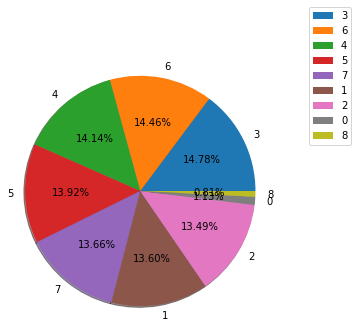

In [45]:
# Some exploration about tilt and pan which are labels 
a = X_train['tilt'].value_counts()
x1 = a.index
fig1 = plt.figure()
ax = fig1.add_axes([0,0,0.5,0.5])
ax.pie(a,autopct ='%.2f%%',labels = x1,shadow = True, radius= 2.0)
ax.legend(loc = "right", bbox_to_anchor=(2,1.3,0,0))
plt.show()

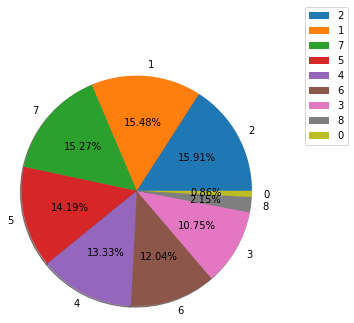

In [46]:
a = X_val['tilt'].value_counts()
x1 = a.index
fig1 = plt.figure()
ax = fig1.add_axes([0,0,0.5,0.5])
ax.pie(a,autopct ='%.2f%%',labels = x1,shadow = True, radius= 2.0)
ax.legend(loc = "right", bbox_to_anchor=(2,1.3,0,0))
plt.show()

# Reading Images with ImageDataGenerator with basic Augmentation

The next step is to read images corresponding to respective datasets for tilt prediction in training and validation data. 
For this purpose, we are using ImageDataGenerator() class in keras.preprocessing.image package.
We can perform various kinds of image augmentations while importing the images like rotation, zoom, horizontal and vertical flip, height-shift, width-shift, adjust brightness, rescaling etc.

As we have a data with labels as directions/angles, its hard to perform many of the augmentation operations like flip, rotation etc because it will change the direction and orientation of image which then is out of synch with labels associated with them.

Hence we are doing some basic Augmentation operations first to check the performance of the model on tilt prediction. If required, we can change those Augmentations to improve performance of model in model tuning phase.

by using featurewise_center to True it will set featurewise mean to zerro for the dataset. then we are rescaling the data by using basic normalization (dividing by 255) and then by choosing data_format as 'channels_last' we are converting image into format [batch_size,image Height, image Width, No of channels].

We are using method named 'flow_from_dataframe()' to read the images and labels from the dataframe. Here, we are converting all the images into 'grayscale' format so that we can extract most features from them and  to size (32x32) from their original size. As we are using classification approach for solving this problem our class mode should be 'categorical' and we are using standard batch size as 32. If required we can change the batch size to check the impact of it on the performance of a model.



We are creating 3 ImageDataGenerators to read images from training dataset, validation dataset and test dataset and save them to corresponding generators.

After that, we are creating a sample dataframe to check the training images and validation images after augmentation that happened during importing images.
and tried to print some of the images with their encoded tilt label.

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_train_generator():
  train_datagen = ImageDataGenerator(rescale=1./255,data_format='channels_last')
  train_generator = train_datagen.flow_from_dataframe(
          dataframe=X_train,
          directory='/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment1/Assign1/A1_data/modified_data/modified_data/',
          x_col="filename",
          y_col="tilt",
          target_size=(32, 32),
          batch_size=32,
          color_mode="grayscale",
          class_mode='categorical',
          shuffle = False)
  return train_generator

def make_val_generator():
  val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
  val_generator = val_datagen.flow_from_dataframe(
          dataframe=X_val,
          directory='/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment1/Assign1/A1_data/modified_data/modified_data/',
          x_col="filename",
          y_col="tilt",
          target_size=(32, 32),
          batch_size=32,
          color_mode="grayscale",
          class_mode='categorical',
          shuffle= False)
  return val_generator

def make_test_predict_generator():
  test_datagen = ImageDataGenerator(rescale=1./255,data_format = 'channels_last')
  test_generator = test_datagen.flow_from_dataframe(
          dataframe= DF_Test,
          directory='/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment1/Assign1/A1_data/modified_data/modified_data/',
          x_col="filename",
          target_size=(32, 32),
          batch_size=32,
          color_mode="grayscale",
          class_mode= None,
          shuffle= False)
  return test_generator


train_dataset = tf.data.Dataset.from_generator(make_train_generator,output_types=(tf.float32, tf.float32), output_shapes=([32,32,32,1], [32,9]))
validation_dataset = tf.data.Dataset.from_generator(make_val_generator,output_types=(tf.float32, tf.float32), output_shapes=([32,32,32,1], [32,9]))

We are printing random 6 of the augmented images to see if the augmentation takes place and data is generated from ImageDataGenerator. We can also see from below output that tilt labels are onne hot encoded.

Found 1860 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


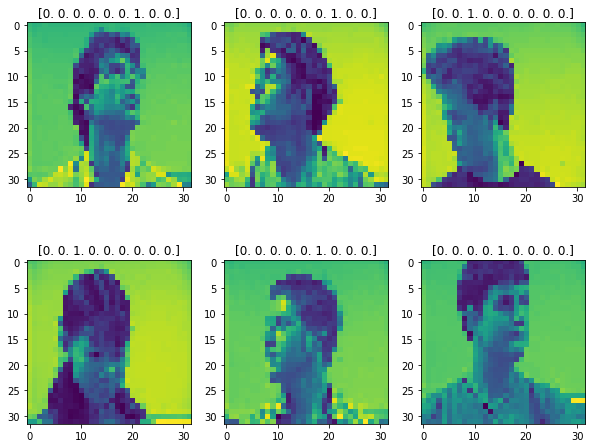

In [48]:
plt.figure(figsize=(10,8))
i=1
for image,label in train_dataset.take(6):
  plt.subplot(2,3,i)
  plt.imshow(image[0,:,:,0])
  plt.title(label[0,:].numpy())
  i=i+1

# Building a Deep Convolutional Network.

* Before building a CNN model, the first step is to decide an error metric and performance metric for our project. As we know our problem is to predict tilt class for the images. As we see above that tilt label have 9 different class values, we will simply consider Categorical Crossentropy as our error metric and Accuracy as our performance metric.

*  We First consider the traditional LeNet5 Architechture to build our model with some changes in the number of layers and number of trainable parameters.
**LeNet5** is CNN classic architechture that existed for so lonag and is used for prediction of hand written notes. The below developed model takes inspiration from it but with some advancements in case of number of layers, Kernel size, Stride size and Activation functions ('Relu' is used instead of  'Sigmoid' as we are using Stochastic Gradient Descent optimization for our model).

* We will first go with a simple CNN architechture consisting of 3 Convolutional layers and 2 dense layers. we are using non-linear activation function as 'Relu' (Rectified Linear unit) which fits good with the optimizer 'Adam()' which is the advanced version of stochastic Gradient Descent.

* The next step is while disigning the model, we are using extraction power of partially build model to disign both tilt_model and pan_model. That means, we are designing a models which uses same convolutional layers and use same power to extract features for tilt and pan prediction both. 

* To build this architachture, we are defining 3 functions. First function will return partially buid model till Convolutional layers. Second function is specific to generate tilt prediction model and thirst function is specific to the pan prediction model.

* We are using maxpooling layers with stride (2, 2) to achieve maximum from the feature extraction and to avoid overfiiting the model has some Kernel L2 regularizers and dropout layers.

* In the end we are using 'softmax' activation function to predict class labels for tilt and pan.

* we will built and run this simple basic model on train and validation data to check if this model is overfitting and then we will try some hyper parameter tuning to achieve some more from the model if the model is giving low performance.


In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

def get_conv_model():
  model_cnn = Sequential()

  # input
  model_cnn.add(Input(shape=(32,32,1)))

  # Conv Layer 1
  model_cnn.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001)))
  model_cnn.add(Activation('relu'))
  model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv Layer 2 
  model_cnn.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
  model_cnn.add(Activation('relu'))
  
  # Conv Layer 3
  model_cnn.add(Conv2D(256, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
  model_cnn.add(Activation('relu'))
  model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

  return model_cnn

def tilt_model():

  # to get basic Convolutional model
  model_cnn = get_conv_model()

  # MLP
  model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(128))
  model_cnn.add(Activation('relu'))
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(9))
  model_cnn.add(Activation('softmax'))

  return model_cnn

def pan_model():

  # to get basic covolutional model
  model_cnn = get_conv_model()

  #Conv Layer 4
  #model_cnn.add(Conv2D(256, (3, 3),kernel_regularizer=regularizers.l2(0.01)))
  #model_cnn.add(Activation('relu'))
  #model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

  # MLP
  model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(128))
  model_cnn.add(Activation('relu'))
  model_cnn.add(Dense(64))
  model_cnn.add(Activation('relu'))
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(13))
  model_cnn.add(Activation('softmax'))

  return model_cnn

In [50]:
m_histories = {}

def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

model_tilt = tilt_model()  
model_tilt.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=[tf.losses.CategoricalCrossentropy(name='CategoricalCrossentropy'), 'accuracy'])


In the next code cell we will show the model summary with output shape after each layer and number of trainable parameters after each layer in the above model.
This will help us to understand model working more appropriately and help us in tuning the model if the performance is low (or overfitting occurs).

In [51]:
model_tilt.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
activation_11 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
activation_12 (Activation)   (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
activation_13 (Activation)   (None, 11, 11, 256)      

In [52]:
train_generator = make_train_generator()
val_generator = make_val_generator()
m_histories['Tilt_Pred'] = model_tilt.fit_generator(train_generator, 
                                                    epochs=100, 
                                                    validation_data=val_generator, 
                                                    verbose=2, 
                                                    callbacks=get_callbacks('models/Tilt_Pred')
                                                    )

Found 1860 validated image filenames belonging to 9 classes.
Found 465 validated image filenames belonging to 9 classes.
Epoch 1/100
59/59 - 4s - loss: 2.1873 - CategoricalCrossentropy: 2.0659 - accuracy: 0.1677 - val_loss: 2.0422 - val_CategoricalCrossentropy: 1.9798 - val_accuracy: 0.2452
Epoch 2/100
59/59 - 4s - loss: 1.8841 - CategoricalCrossentropy: 1.8268 - accuracy: 0.2769 - val_loss: 1.6841 - val_CategoricalCrossentropy: 1.6304 - val_accuracy: 0.3634
Epoch 3/100
59/59 - 4s - loss: 1.6426 - CategoricalCrossentropy: 1.5909 - accuracy: 0.3704 - val_loss: 1.5543 - val_CategoricalCrossentropy: 1.5019 - val_accuracy: 0.4409
Epoch 4/100
59/59 - 4s - loss: 1.5097 - CategoricalCrossentropy: 1.4604 - accuracy: 0.4102 - val_loss: 1.4310 - val_CategoricalCrossentropy: 1.3789 - val_accuracy: 0.4839
Epoch 5/100
59/59 - 4s - loss: 1.4070 - CategoricalCrossentropy: 1.3568 - accuracy: 0.4624 - val_loss: 1.2937 - val_CategoricalCrossentropy: 1.2417 - val_accuracy: 0.5247
Epoch 6/100
59/59 - 4s -

We can see from the above training of a model that model is working fine with average accuracy of 85% which is good for tilt prediction. but the performance of a model is best visualised with error plot and accuracy plot which is also called learning curves.

In the below cells, we are plotting learning curves of a model for error metric Categorical Crossextropy and performance metric Accuracy. We can see from these learning curves that our model is not overfitting and showing steady decrease in Categorical Crossentropy values which represents our model is working fine with predicting the tilt values.

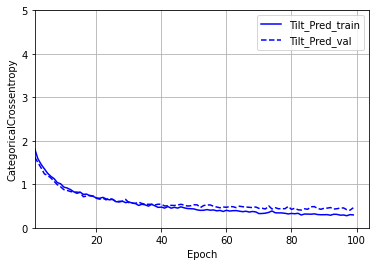

In [53]:
plotter(m_histories, ylim=[0.0, 5.0], metric = 'CategoricalCrossentropy')

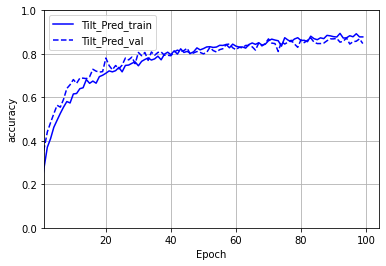

In [54]:
plotter(m_histories, ylim=[0.0, 1.0], metric = 'accuracy')

The next step is to predict the tilt labels for the images in 'test_data.csv'. For this we have imported thos images with test_generator which is ImageDataGenerator and then we will apply .predict function of our trained model to predict the tilt angles for unseen images.


In [55]:
test_generator = make_test_predict_generator()
predictions = model_tilt.predict_generator(test_generator, verbose= 1)

Found 465 validated image filenames.
15/15 [==============================] - 1s 49ms/step


We will use argmax function to return the predicted class values in readable format and then we are going to replace them with tilt labels as mentioned above while encoding them.


In [56]:
tilt_result = pd.Series (np.argmax(predictions, axis=1).tolist()).replace({0:"-90" , 1:"-60", 2:"-30", 3:"-15", 4:"0", 5:"15", 6:"30", 7:"60", 8:"90"})
tilt_result.head(10)

0    60
1    60
2     0
3    15
4    15
5    30
6    60
7    30
8    60
9    30
dtype: object



---

# **Pan Prediction**

We will do the similar functionality to check the distribution of pan class labels as we did it for tilt. We can see from below cells that, class labels for pan are almost equally distributed.
we can see it more clearly with the help of small visualization of pie charts as drawn below.
We can see that there are 13 different values for pan class label which we have to predict in this problem. 
In the starting cells awe divide the training data into training and validation datasets using train_test-split functionality. 
we encoded the values of pan class (-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90)  as (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12).


In [85]:
print(X_train['pan'].value_counts())

6     174
12    147
1     146
11    144
8     143
2     143
10    142
9     142
7     142
5     137
0     135
3     133
4     132
Name: pan, dtype: int64


In [86]:
print(X_val['pan'].value_counts())

6     51
4     43
3     42
0     40
5     38
7     33
10    33
9     33
2     32
8     32
11    31
1     29
12    28
Name: pan, dtype: int64


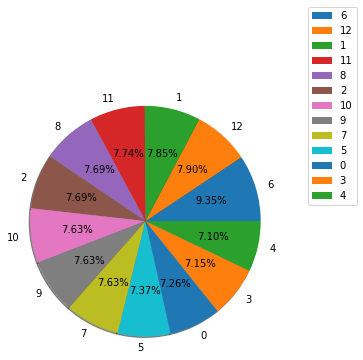

In [87]:
# Some exploration about tilt and pan which are labels 
a = X_train['pan'].value_counts()
x1 = a.index
fig1 = plt.figure()
ax = fig1.add_axes([0,0,0.5,0.5])
ax.pie(a,autopct ='%.2f%%',labels = x1,shadow = True, radius= 2.0)
ax.legend(loc = "right", bbox_to_anchor=(2,1.3,0,0))
plt.show()

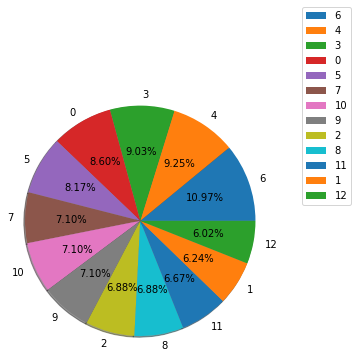

In [88]:
# Some exploration about tilt and pan which are labels 
a = X_val['pan'].value_counts()
x1 = a.index
fig1 = plt.figure()
ax = fig1.add_axes([0,0,0.5,0.5])
ax.pie(a,autopct ='%.2f%%',labels = x1,shadow = True, radius= 2.0)
ax.legend(loc = "right", bbox_to_anchor=(2,1.3,0,0))
plt.show()

# Reading Images with ImageDataGenerator with basic Augmentation

The next step is to read images corresponding to respective datasets for pan prediction in training and validation data. 
We can perform various kinds of image augmentations while importing the images like rotation, zoom, horizontal and vertical flip, height-shift, width-shift, adjust brightness, rescaling etc.

As we have a data with labels as directions/angles, its hard to perform many of the augmentation operations like flip, rotation etc because it will change the direction and orientation of image which then is out of synch with labels associated with them.

Hence we are doing some basic Augmentation operations first to check the performance of the model on pan prediction. If required, we can change those Augmentations to improve performance of model in model tuning phase.

we shift the Height range by 0.1 just to fit the whole image in (32,32) format. then we are rescaling the data by using basic normalization (dividing by 255) and then by choosing data_format as 'channels_last' we are converting image into format [batch_size,image Height, image Width, No of channels].

In [102]:
def make_pan_train_generator():
  train_datagen = ImageDataGenerator(rescale=1./255,data_format='channels_last')
  train_generator = train_datagen.flow_from_dataframe(
          dataframe=X_train,
          directory='/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment1/Assign1/A1_data/modified_data/modified_data/',
          x_col="filename",
          y_col="pan",
          target_size=(32, 32),
          batch_size=32,
          color_mode="grayscale",
          class_mode='categorical',
          shuffle = False)
  return train_generator


def make_pan_val_generator():
  val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
  val_generator = val_datagen.flow_from_dataframe(
          dataframe=X_val,
          directory='/content/drive/My Drive/ColabNotebooks/DeepLearningLabs/Assignment1/Assign1/A1_data/modified_data/modified_data/',
          x_col="filename",
          y_col="pan",
          target_size=(32, 32),
          batch_size=32,
          color_mode="grayscale",
          class_mode='categorical',
          shuffle= False)
  return val_generator

train_dataset = tf.data.Dataset.from_generator(make_pan_train_generator,output_types=(tf.float32, tf.float32), output_shapes=([32,32,32,1], [32,13]))
validation_dataset = tf.data.Dataset.from_generator(make_pan_val_generator,output_types=(tf.float32, tf.float32), output_shapes=([32,32,32,1], [32,13]))

We can see some sample images from the created datasets to check if the augmentation and importing part is done correctly.
We can see from the output that,  the images are imported and augmented correctly and are in grayscale format as well.

Found 1860 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


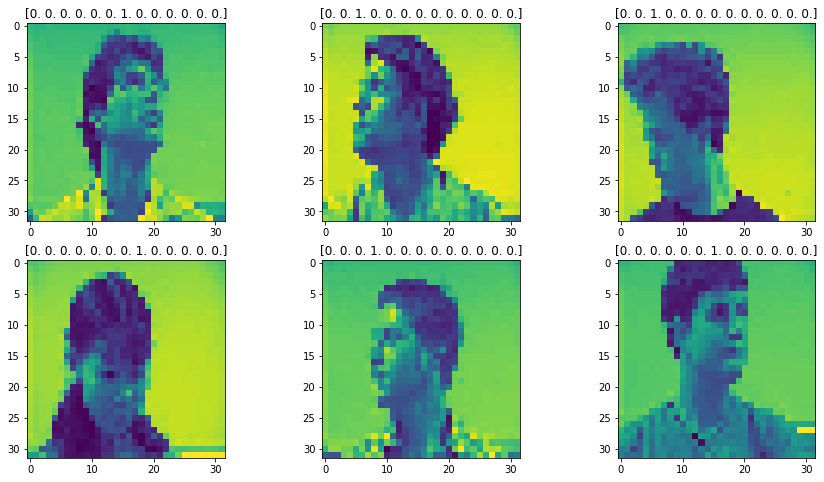

In [103]:
plt.figure(figsize=(15,8))
i=1
for image,label in train_dataset.take(6):
  plt.subplot(2,3,i)
  plt.imshow(image[0,:,:,0])
  plt.title(label[0,:].numpy())
  i=i+1

# Build and Compilation of pan prediction model

As stated above we are using power of partially built model for tilt prediction for pan prediction as well. That means wee are using same model till convolutional layers for pan prediction and hence we structured our pan model using functions stated above.

We are using same error and performance metrics as that in tilt prediction which are CategoricalCrossentropy and Accuracy respectively.

In the Pan model we are first build a model same as that of tilt but it gave us a lower performance and hence we came up with increasing some depth in the model by adding an extra dense layer to make it step-up and then step-down kind of model.

Hence we are using 3 Dense layers in the architechture of pan model. Further, we have chosen 'Adam()' optimizer which works good with our non-linear activation function 'Relu' and which is an advanced version of Stochastic Gradient Descent algorithm used for the loss optimization.

In [104]:
m_histories = {}

def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

model_pan = pan_model()  
model_pan.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=[tf.losses.CategoricalCrossentropy(name='CategoricalCrossentropy'), 'accuracy'])

We can see the network architechture more closely with the help of model summary. It will give us brief undersatanding of the output shape after each layer of a model and number of trainable parameters after each layer. 

In [105]:
model_pan.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_34 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
activation_35 (Activation)   (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 256)       295168    
_________________________________________________________________
activation_36 (Activation)   (None, 11, 11, 256)      

After compiling the model we can train our model for 100 epochs and store it to see the learning curves for our model. 


In [106]:
train_generator = make_pan_train_generator()
val_generator = make_pan_val_generator()
m_histories['Pan_Pred'] = model_pan.fit_generator(train_generator, 
                                                    epochs=100, 
                                                    validation_data=val_generator, 
                                                    verbose=2, 
                                                    callbacks=get_callbacks('models/Pan_Pred')
                                                    )

Found 1860 validated image filenames belonging to 13 classes.
Found 465 validated image filenames belonging to 13 classes.
Epoch 1/100
59/59 - 4s - loss: 2.6869 - CategoricalCrossentropy: 2.5700 - accuracy: 0.0763 - val_loss: 2.6159 - val_CategoricalCrossentropy: 2.5650 - val_accuracy: 0.1097
Epoch 2/100
59/59 - 4s - loss: 2.5982 - CategoricalCrossentropy: 2.5648 - accuracy: 0.0801 - val_loss: 2.5859 - val_CategoricalCrossentropy: 2.5652 - val_accuracy: 0.1097
Epoch 3/100
59/59 - 4s - loss: 2.5794 - CategoricalCrossentropy: 2.5649 - accuracy: 0.0909 - val_loss: 2.5738 - val_CategoricalCrossentropy: 2.5642 - val_accuracy: 0.1097
Epoch 4/100
59/59 - 4s - loss: 2.5710 - CategoricalCrossentropy: 2.5641 - accuracy: 0.0935 - val_loss: 2.5685 - val_CategoricalCrossentropy: 2.5637 - val_accuracy: 0.1097
Epoch 5/100
59/59 - 4s - loss: 2.5684 - CategoricalCrossentropy: 2.5645 - accuracy: 0.0946 - val_loss: 2.5658 - val_CategoricalCrossentropy: 2.5630 - val_accuracy: 0.1097
Epoch 6/100
59/59 - 4s

We can similarly check the learning curve for pan prediction of error metric as well as for performance metric.
We can see that, the pan prediction model is performing with almost 70% validation data accuracy. 


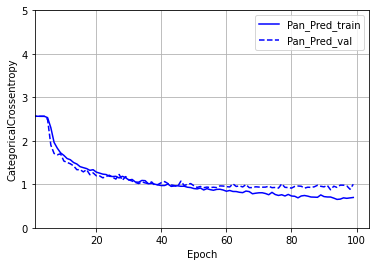

In [107]:
plotter(m_histories, ylim=[0.0, 5.0], metric = 'CategoricalCrossentropy')

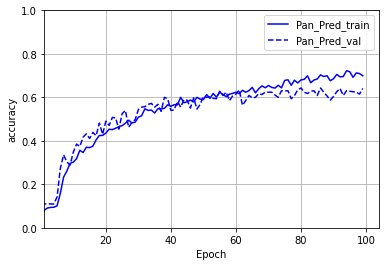

In [108]:
plotter(m_histories, ylim=[0.0, 1.0], metric = 'accuracy')

The next step is to predict the pan labels for 'test_data.csv' file images. For this we are using 'mode.predict_generator' function which takes in the test generator created above and predict the pan labels for them.

Then next step is to convert them into readable format an decode them to the class values.

In [109]:
test_generator = make_test_predict_generator()
predictions = model_pan.predict_generator(test_generator, verbose= 1)

Found 465 validated image filenames.
15/15 [==============================] - 1s 48ms/step


In [110]:
pan_result = pd.Series (np.argmax(predictions, axis=1).tolist()).replace({0:"-90" , 1: "-75", 2:"-60", 3:"-45", 4:"-30", 5:"-15", 6:"0", 7:"15", 8:"30", 9:"45", 10:"60", 11:"75", 12:"90"})
pan_result.head(10)

0     30
1     75
2     75
3     30
4      0
5    -45
6     60
7    -15
8    -60
9    -45
dtype: object

In [ ]:
df = pd.DataFrame()
df['pan_result'] = pan_result
df['tilt_result'] = tilt_result

In [ ]:
df.shape
df.to_excel("Output.xlsx")